In [2]:
import yfinance as yf
import pandas as pd

# Define the tickers for the assets we need
tickers = ['TSLA', 'BND', 'SPY']

# Set the start and end dates for our data
start_date = '2015-07-01'
end_date = '2025-07-31'

# Fetch the data using yfinance
data = yf.download(tickers, start=start_date, end=end_date, timeout=10)

print("✅ Data downloaded successfully!")

# Verify the first few rows
print("\n--- First 5 Rows ---")
print(data.head())

# Verify the last few rows
print("\n--- Last 5 Rows ---")
print(data.tail())

/tmp/ipykernel_57268/120464032.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, timeout=10)
[*********************100%***********************]  3 of 3 completed

✅ Data downloaded successfully!

--- First 5 Rows ---
Price           Close                              High              \
Ticker            BND         SPY       TSLA        BND         SPY   
Date                                                                  
2015-07-01  60.816746  174.917130  17.943333  60.914471  175.363905   
2015-07-02  60.967098  174.756882  18.667999  61.027240  175.566142   
2015-07-06  61.177597  174.259613  18.648001  61.222706  175.043573   
2015-07-07  61.237705  175.355438  17.858667  61.470746  175.481879   
2015-07-08  61.410606  172.413498  16.997334  61.463229  174.293327   

Price                        Low                              Open  \
Ticker           TSLA        BND         SPY       TSLA        BND   
Date                                                                 
2015-07-01  18.174667  60.764123  174.124732  17.856667  60.794194   
2015-07-02  18.830000  60.937027  174.335395  18.220667  60.937027   
2015-07-06  18.779333  61.0

In [3]:
# Assuming 'data' is the DataFrame from the previous step

# 1. Simplify the DataFrame to only include 'Close'
close_df = data['Close']
print("--- Simplified DataFrame with Closing Prices ---")
print(close_df.head())

# 2. Check for any missing values (NaNs)
print("\n--- Initial Check for Missing Values ---")
print(close_df.isnull().sum())

# 3. Handle missing values using forward-fill
# This propagates the last valid observation forward. It's a good choice for
# time series data as it assumes the value remains the same on non-trading days.
close_df = close_df.ffill()

# 4. Verify that all missing values have been handled
print("\n--- Verification after Handling Missing Values ---")
print(close_df.isnull().sum())

--- Simplified DataFrame with Closing Prices ---
Ticker            BND         SPY       TSLA
Date                                        
2015-07-01  60.816746  174.917130  17.943333
2015-07-02  60.967098  174.756882  18.667999
2015-07-06  61.177597  174.259613  18.648001
2015-07-07  61.237705  175.355438  17.858667
2015-07-08  61.410606  172.413498  16.997334

--- Initial Check for Missing Values ---
Ticker
BND     0
SPY     0
TSLA    0
dtype: int64

--- Verification after Handling Missing Values ---
Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


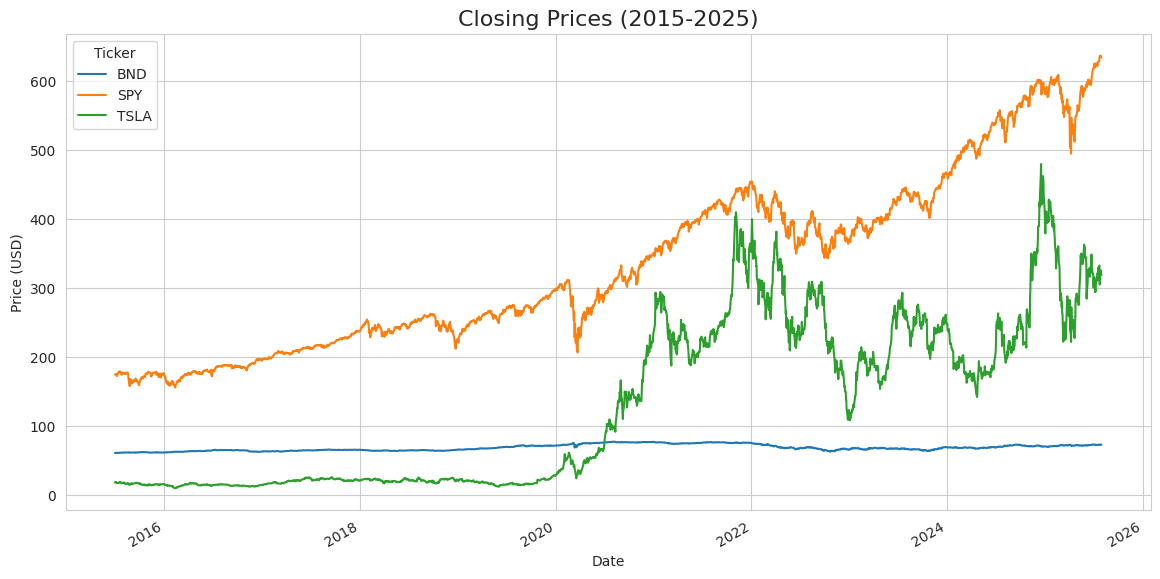

In [4]:
# Assuming 'close_df' is your cleaned DataFrame from the previous step
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')
plt.figure(figsize=(14, 7))

# Plot the closing prices for each asset
close_df.plot(ax=plt.gca())

# Add titles and labels for clarity
plt.title('Closing Prices (2015-2025)', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(title='Ticker')
plt.show()

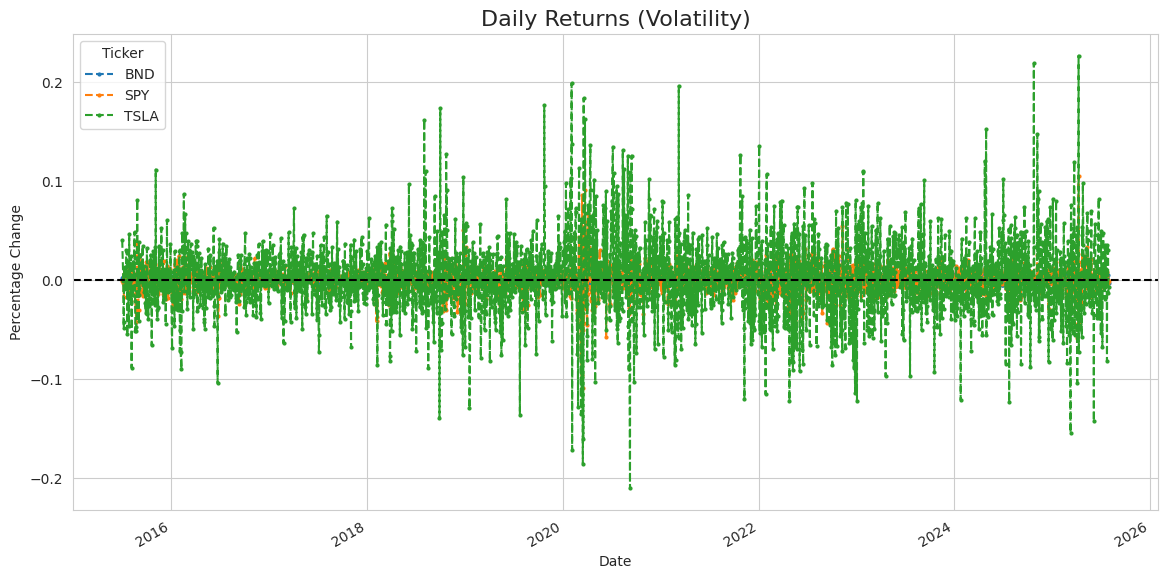

In [5]:
# Calculate daily percentage returns
daily_returns = close_df.pct_change().dropna()

# Plot the daily returns
daily_returns.plot(figsize=(14, 7), legend=True, linestyle='--', marker='o', ms=2)

plt.title('Daily Returns (Volatility)', fontsize=16)
plt.ylabel('Percentage Change')
plt.xlabel('Date')
plt.axhline(0, color='black', linestyle='--') # Add a line at zero
plt.show()

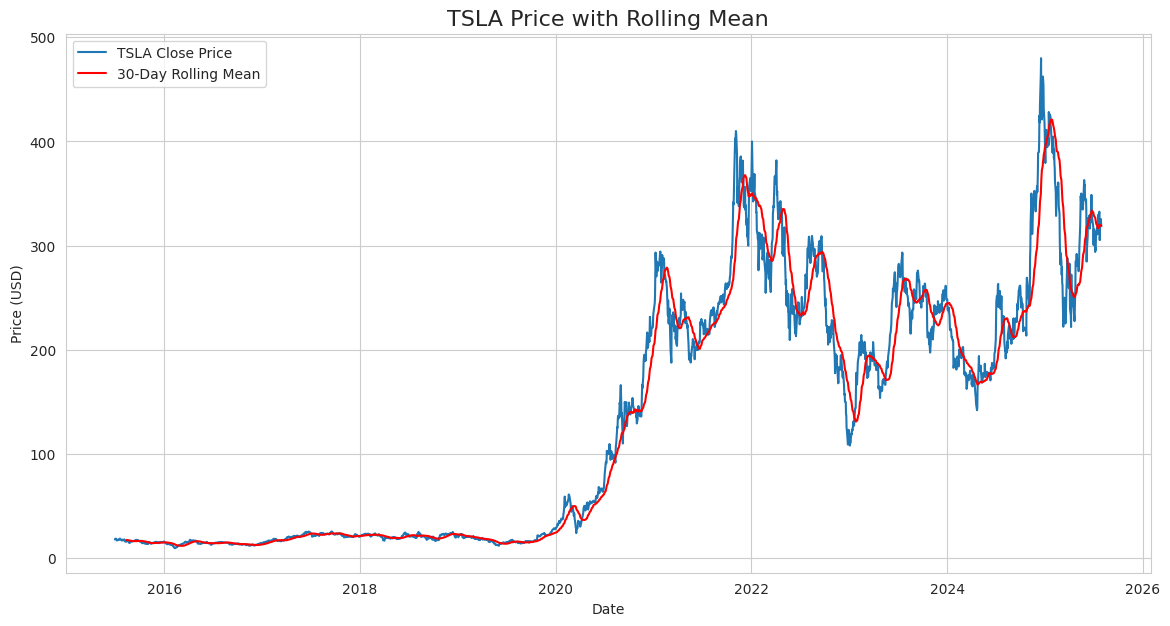

In [6]:
# Set the window for the rolling statistics (e.g., 30 days)
rolling_window = 30

# Calculate rolling mean and standard deviation for TSLA
rolling_mean_tsla = close_df['TSLA'].rolling(window=rolling_window).mean()
rolling_std_tsla = close_df['TSLA'].rolling(window=rolling_window).std()

# Plot the original p1rice and the rolling mean
plt.figure(figsize=(14, 7))
plt.plot(close_df['TSLA'], label='TSLA Close Price')
plt.plot(rolling_mean_tsla, label=f'{rolling_window}-Day Rolling Mean', color='red')
plt.title('TSLA Price with Rolling Mean', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

# Function to run and interpret the ADF test
def run_adf_test(series, name=''):
    result = adfuller(series)
    print(f'--- ADF Test Results for {name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis. Data is likely stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.")
    print('-' * 40)

# Assuming 'close_df' and 'daily_returns' are from the previous steps
# Test 1: On the non-stationary closing price
run_adf_test(close_df['TSLA'].dropna(), name='TSLA Close Price')

# Test 2: On the daily returns
run_adf_test(daily_returns['TSLA'].dropna(), name='TSLA Daily Returns')


--- ADF Test Results for TSLA Close Price ---
ADF Statistic: -1.4189
p-value: 0.5732
Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.
----------------------------------------
--- ADF Test Results for TSLA Daily Returns ---
ADF Statistic: -34.6811
p-value: 0.0000
Conclusion: Reject the null hypothesis. Data is likely stationary.
----------------------------------------


In [8]:
import numpy as np

# --- Value at Risk (VaR) ---
# Calculate 95% VaR for each asset
confidence_level = 0.05
var_95 = daily_returns.quantile(confidence_level)

print(f"--- 95% Value at Risk (VaR) ---")
print("This means on 5% of days, we can expect a loss of at least:")
print(var_95.apply(lambda x: f"{x:.2%}"))

# --- Sharpe Ratio ---
# Assuming a risk-free rate of 0 for simplicity
# The number of trading days in a year is typically 252
risk_free_rate = 0
mean_returns = daily_returns.mean()
std_dev = daily_returns.std()

sharpe_ratio = (mean_returns - risk_free_rate) / std_dev
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)

print("\n--- Annualized Sharpe Ratio ---")
print("A higher value indicates better risk-adjusted returns.")
print(annualized_sharpe_ratio.round(2))

--- 95% Value at Risk (VaR) ---
This means on 5% of days, we can expect a loss of at least:
Ticker
BND     -0.49%
SPY     -1.72%
TSLA    -5.47%
Name: 0.05, dtype: object

--- Annualized Sharpe Ratio ---
A higher value indicates better risk-adjusted returns.
Ticker
BND     0.36
SPY     0.79
TSLA    0.78
dtype: float64


In [13]:
# Save the cleaned DataFrame to a CSV file for future use
output_file = '../data/cleaned_financial_data.csv'
close_df.to_csv(output_file)
print(f"\n✅ Cleaned data saved to {output_file}")


✅ Cleaned data saved to ../data/cleaned_financial_data.csv
